In [2]:
% matplotlib inline
% env CUDA_VISIBLE_DEVICES=0

env: CUDA_VISIBLE_DEVICES=0


In [3]:
import sys; sys.path += ['..', '../src']

In [4]:
import os
from src.vocab import Vocab

DATA_PATH = '../data/generated'
max_len = 100

get_path = lambda d: os.path.join(DATA_PATH, d)
read_data = lambda d: open(get_path(d)).read().splitlines()
tokenize = lambda c,v: [[v.token2id.get(t, v.unk) for t in s.split()] for s in c]
cut_len = lambda c: [s[:max_len-2] for s in c]

train_src = read_data('europarl.en.tok.bpe')
train_trg = read_data('europarl.fr.tok.bpe')

# Let's remove empty sentences
filter_empty = lambda c,empty_idx: [s for i,s in enumerate(c) if not i in empty_idx]
get_empty_idx = lambda src,trg: set(i for i,(s,t) in enumerate(zip(src, trg)) if len(s) == 0 or len(t) == 0)
empty_idx = get_empty_idx(train_src, train_trg)
train_src = filter_empty(train_src, empty_idx)
train_trg = filter_empty(train_trg, empty_idx)

vocab_src = Vocab.from_sequences(train_src)
vocab_trg = Vocab.from_sequences(train_trg)

train_src_idx = cut_len(tokenize(train_src, vocab_src))
train_trg_idx = cut_len(tokenize(train_trg, vocab_trg))

In [28]:
from sklearn.model_selection import train_test_split

train_src_idx, val_src_idx = train_test_split(train_src_idx, test_size=1000, random_state=42)
train_trg_idx, val_trg_idx = train_test_split(train_trg_idx, test_size=1000, random_state=42)

In [31]:
import torch
import torch.nn as nn

from src.vocab import constants

class CNN(nn.Module):
    def __init__(self, dim_size, vocab_src_len, vocab_trg_len, kernel_size=5, dropout_p=0.2):
        super(CNN, self).__init__()
        
        self.embed = nn.Embedding(vocab_src_len, dim_size, padding_idx=constants.PAD)
        
        self.conv_1_1 = nn.Conv1d(dim_size, dim_size//2, kernel_size, padding=kernel_size//2)
        self.selu_1_1 = nn.SELU()
        self.conv_1_2 = nn.Conv1d(dim_size//2, dim_size//2, kernel_size, padding=kernel_size//2)
        self.selu_1_2 = nn.SELU()
        self.conv_1_3 = nn.Conv1d(dim_size//2, dim_size//2, kernel_size, padding=kernel_size//2)
        self.selu_1_3 = nn.SELU()
        self.conv_1_4 = nn.Conv1d(dim_size//2, dim_size//2, kernel_size, padding=kernel_size//2)
        self.selu_1_4 = nn.SELU()
        self.drop_1 = nn.Dropout2d(dropout_p)
        
        # Now we should start increasing sequence length (by adding paddings)
        self.conv_2_1 = nn.Conv1d(dim_size//2, dim_size//2, kernel_size, padding=kernel_size-1)
        self.selu_2_1 = nn.SELU()
        self.conv_2_2 = nn.Conv1d(dim_size//2, dim_size//2, kernel_size, padding=kernel_size-1)
        self.selu_2_2 = nn.SELU()
        self.conv_2_3 = nn.Conv1d(dim_size//2, dim_size//2, kernel_size, padding=kernel_size-1)
        self.selu_2_3 = nn.SELU()
        self.conv_2_4 = nn.Conv1d(dim_size//2, dim_size//2, kernel_size, padding=kernel_size-1)
        self.selu_2_4 = nn.SELU()
        self.drop_2_1 = nn.Dropout2d(dropout_p)
        self.conv_2_5 = nn.Conv1d(dim_size//2, dim_size//2, kernel_size, padding=kernel_size-1)
        self.selu_2_5 = nn.SELU()
        self.conv_2_6 = nn.Conv1d(dim_size//2, dim_size//2, kernel_size, padding=kernel_size//2)
        self.selu_2_6 = nn.SELU()
        self.conv_2_7 = nn.Conv1d(dim_size//2, dim_size//2, kernel_size, padding=kernel_size//2)
        self.selu_2_7 = nn.SELU()
        self.conv_2_8 = nn.Conv1d(dim_size//2, dim_size//2, kernel_size, padding=kernel_size//2)
        self.selu_2_8 = nn.SELU()
        self.drop_2_2 = nn.Dropout2d(dropout_p)
        
        # Now we would like to make several increases-decreases of number of channels
        self.conv_3_1 = nn.Conv1d(dim_size//2, dim_size, kernel_size, padding=kernel_size//2)
        self.selu_3_1 = nn.SELU()
        self.conv_3_2 = nn.Conv1d(dim_size, dim_size*2, kernel_size, padding=kernel_size//2)
        self.selu_3_2 = nn.SELU()
        self.conv_3_3 = nn.Conv1d(dim_size*2, dim_size, kernel_size, padding=kernel_size//2)
        self.selu_3_3 = nn.SELU()
        self.conv_3_4 = nn.Conv1d(dim_size, dim_size//2, kernel_size, padding=kernel_size//2)
        self.selu_3_4 = nn.SELU()
        self.drop_3_1 = nn.Dropout2d(dropout_p)
        self.conv_3_5 = nn.Conv1d(dim_size//2, dim_size, kernel_size, padding=kernel_size//2)
        self.selu_3_5 = nn.SELU()
        self.conv_3_6 = nn.Conv1d(dim_size, dim_size*2, kernel_size, padding=kernel_size//2)
        self.selu_3_6 = nn.SELU()
        self.conv_3_7 = nn.Conv1d(dim_size*2, dim_size, kernel_size, padding=kernel_size//2)
        self.selu_3_7 = nn.SELU()
        self.conv_3_8 = nn.Conv1d(dim_size, dim_size//2, kernel_size, padding=kernel_size//2)
        self.selu_3_8 = nn.SELU()
        self.drop_3_2 = nn.Dropout2d(dropout_p)
        
        # Now we will decode the sequence
        self.conv_4_1 = nn.Conv1d(dim_size//2, dim_size, kernel_size, padding=kernel_size//2)
        self.selu_4_1 = nn.SELU()
        self.conv_4_2 = nn.Conv1d(dim_size, dim_size, kernel_size, padding=kernel_size//2)
        self.selu_4_2 = nn.SELU()
        self.conv_4_3 = nn.Conv1d(dim_size, dim_size, kernel_size, padding=kernel_size//2)
        self.selu_4_3 = nn.SELU()
        self.conv_4_4 = nn.Conv1d(dim_size, dim_size, kernel_size, padding=kernel_size//2)
        self.selu_4_4 = nn.SELU()
        
        self.vec_to_logits = nn.Linear(dim_size, vocab_trg_len, bias=False)
        
    def forward(self, x):
        x = self.embed(x).transpose(1,2)

        x = self.conv_1_1(x)
        x = self.selu_1_1(x)
        x = self.conv_1_2(x)
        x = self.selu_1_2(x)
        x = self.conv_1_3(x)
        x = self.selu_1_3(x)
        x = self.conv_1_4(x)
        x = self.selu_1_4(x)
        x = self.drop_1(x.transpose(1,2)).transpose(1,2)
        
        x = self.conv_2_1(x)
        x = self.selu_2_1(x)
        x = self.conv_2_2(x)
        x = self.selu_2_2(x)
        x = self.conv_2_3(x)
        x = self.selu_2_3(x)
        x = self.conv_2_4(x)
        x = self.selu_2_4(x)
        x = self.drop_2_1(x.transpose(1,2)).transpose(1,2)
        x = self.conv_2_5(x)
        x = self.selu_2_5(x)
        x = self.conv_2_6(x)
        x = self.selu_2_6(x)
        x = self.conv_2_7(x)
        x = self.selu_2_7(x)
        x = self.conv_2_8(x)
        x = self.selu_2_8(x)
        x = self.drop_2_2(x.transpose(1,2)).transpose(1,2)
        residual = x
        
        x = self.conv_3_1(x)
        x = self.selu_3_1(x)
        x = self.conv_3_2(x)
        x = self.selu_3_2(x)
        x = self.conv_3_3(x)
        x = self.selu_3_3(x)
        x = self.conv_3_4(x)
        x = self.selu_3_4(x)
        x = self.drop_3_1(x.transpose(1,2)).transpose(1,2)
        x = self.conv_3_5(x)
        x = self.selu_3_5(x)
        x = self.conv_3_6(x)
        x = self.selu_3_6(x)
        x = self.conv_3_7(x)
        x = self.selu_3_7(x)
        x = self.conv_3_8(x)
        x = self.selu_3_8(x)
        x = self.drop_3_2(x.transpose(1,2)).transpose(1,2) + residual
        
        x = self.conv_4_1(x)
        x = self.selu_4_1(x)
        x = self.conv_4_2(x)
        x = self.selu_4_2(x)
        x = self.conv_4_3(x)
        x = self.selu_4_3(x)
        x = self.conv_4_4(x)
        x = self.selu_4_4(x)
        
        x = self.vec_to_logits(x.transpose(1,2))
        
        return x

In [32]:
from torch.autograd import Variable

from src.vocab import constants
from src.utils.common import variable

def pull_to_len(var:Variable, length:int):
    """
    Contracts or expands 2D-tensor to a desired length
    filling with PADs
    """
    if var.size(1) == length:
        return var
    elif var.size(1) > length:
        return var[:,:length]
    else:
        num_pads_to_add = length - var.size(1)
        to_add = variable(torch.LongTensor(var.size(0), num_pads_to_add))
        to_add.fill_(constants.PAD)
        to_add.cuda()
        var = torch.cat((var, to_add), 1)
        
        return var

In [33]:
from src.utils.bleu import compute_bleu_for_sents
from src.utils.data_utils import remove_spec_symbols

def compute_bleu(logits, trg):
    logits = logits.view(*trg.size(), logits.size(1))
    tokens = logits.max(dim=2)[1]
    
    tokens = remove_spec_symbols(tokens.data.cpu().numpy().tolist())
    trg = remove_spec_symbols(trg.data.cpu().numpy().tolist())
    
    translations = vocab_trg.remove_bpe_many(vocab_trg.detokenize_many(tokens))
    targets = vocab_trg.remove_bpe_many(vocab_trg.detokenize_many(trg))
    
    bleu = compute_bleu_for_sents(translations, targets)
    
    return bleu, translations, targets

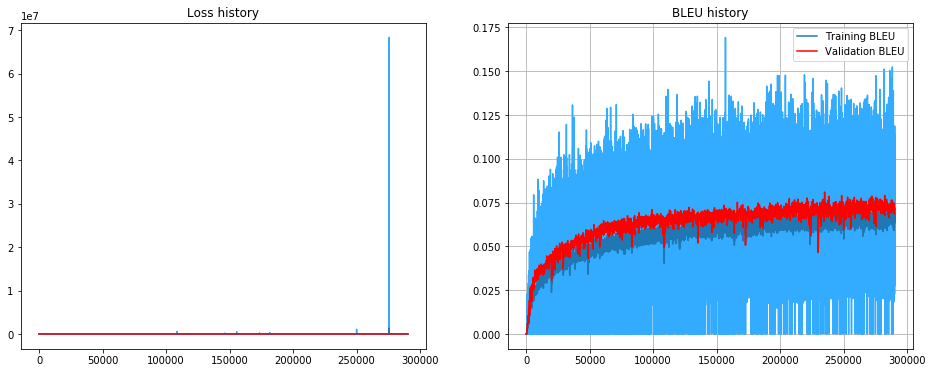

In [34]:
import math
import numpy as np
from IPython.display import clear_output
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline

import torch
import torch.nn as nn
from torch.optim import Adam
from tqdm import tqdm; tqdm.monitor_interval = 0

from src.dataloaders import Batcher
from src.vocab import constants

use_cuda = torch.cuda.is_available()

model = CNN(512, len(vocab_src), len(vocab_trg))
optimizer = Adam(model.parameters(), lr=1e-4, betas=(0.9, 0.98))
criterion = nn.CrossEntropyLoss()
training_data = Batcher(train_src_idx, train_trg_idx, vocab_src.token2id,
                        vocab_trg.token2id, batch_size=32, shuffle=True)
val_data = Batcher(val_src_idx[:256], val_trg_idx[:256], vocab_src.token2id,
                   vocab_trg.token2id, batch_size=32, shuffle=False)

if use_cuda:
    model.cuda()

model.train()
loss_history = []
bleu_history = []
val_loss_history = []
val_iters = []
val_bleu_history = []
num_iters_done = 0
max_num_epochs = 50

try:
    for i in range(max_num_epochs):
        for batch in tqdm(training_data, leave=False):
            src, trg = batch
            optimizer.zero_grad()
            pred = model(src)
            trg = pull_to_len(trg, pred.size(1))
            pred = pred.view(-1, len(vocab_trg))
            
            loss = criterion(pred, trg.contiguous().view(-1))
            bleu = compute_bleu(pred, trg)[0]
            loss.backward()
            optimizer.step()

            loss_history.append(loss.data[0])
            bleu_history.append(bleu)

            if num_iters_done % 50 == 0:
                clear_output(True)
                plt.figure(figsize=[16,6])
                plt.subplot(121)
                plt.title("Loss history")
                plt.plot(loss_history, color='#33ACFF')
                plt.plot(pd.DataFrame(np.array(loss_history)).ewm(span=100).mean(), label='Training loss')
                plt.plot(val_iters, val_loss_history, label='Validation loss', c='red')
                
                plt.subplot(122)
                plt.title('BLEU history')
                plt.plot(bleu_history, color='#33ACFF')
                plt.plot(pd.DataFrame(np.array(bleu_history)).ewm(span=100).mean(), label='Training BLEU')
                plt.plot(val_iters, val_bleu_history, label='Validation BLEU', c='red')
                
                plt.grid()
                plt.legend()
                plt.show()

            if num_iters_done % 100 == 0:
                val_losses = []
                val_bleus = []
                
                for val_batch in val_data:
                    val_src, val_trg = val_batch
                    val_pred = model(val_src)
                    val_trg = pull_to_len(val_trg, val_pred.size(1))
                    val_pred = val_pred.view(-1, len(vocab_trg))
                    val_loss = criterion(val_pred, val_trg.contiguous().view(-1))
                    val_losses.append(val_loss.data[0])
                    val_bleu = compute_bleu(val_pred, val_trg)[0]
                    val_bleus.append(val_bleu)

                val_loss_history.append(np.mean(val_losses))
                val_bleu_history.append(np.mean(val_bleus))
                val_iters.append(num_iters_done)

            num_iters_done += 1
except KeyboardInterrupt:
    pass

In [38]:
bleu, translations, targets = compute_bleu(val_pred, val_trg)

In [39]:
bleu

0.06141718943374383

In [43]:
for i in range(5):
    print('Translation:', translations[i])
    print('Target:     ', targets[i])
    print()

Translation: Bien que certains ne de de de de de de politique politique politiques raisons raisons raisons politiques , , , qui qui qui qui d de de l l l , , , , , , , , , , , , , , , , humains humains humains humains humains humains , de de de de un un
Target:      S'il existe certainement des personnes qui embrassent l'extrémisme politique pour des raisons politiques , il en existe d'autres qui s'en servent pour cacher leurs agissements criminels - trafic de stupéfiants , trafic de cigarettes , trafic d'êtres humains ils utilisent les idéaux politiques comme un moyen de couvrir leurs activités criminelles . Quoi qu'il en soit , cela est inacceptable .

Translation: Nous voulons tous nous une réponse réponse aux aux . . .
Target:      Nous appelons tous de nos vœux une meilleure réaction en cas d'urgence .

Translation: Troisièmement , si si le de doit être être être être être être , doit doit être être scientifique base et et et et
Target:      Troisièmement , l'interdiction de la ch